In this notebook, we demonstrate the experimental dask-yt particle loader in `./dask_chunking/gadget_da.py` 

The dask approach here attempts to wrap the loading and filtering of individual chunks with the `dask.delayed` operator (to various degress of success...), resulting in a lazy load of a `gadget` particle dataset that is automatically parallelized when running a `dask.distributed.Client`. 


In [1]:
from dask_chunking import gadget_da as gda
from dask import compute, visualize
import yt 
import numpy as np

First, let's spin up a dask `Client`:

In [2]:
from dask.distributed import Client 

In [3]:
c = Client(threads_per_worker=2,n_workers=4)

In [4]:
c

Client Scheduler: tcp://127.0.0.1:35151 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.51 GB


and import a `gadget` dataset. 

In [5]:
ds = yt.load_sample("snapshot_033")

yt : [WARNING  ] 2020-09-23 12:26:51,646 tqdm is not installed, progress bar can not be displayed.
yt : [INFO     ] 2020-09-23 12:26:52,166 Files located at /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.
yt : [INFO     ] 2020-09-23 12:26:52,167 Default to loading snap_033.0.hdf5 for snapshot_033 dataset
yt : [INFO     ] 2020-09-23 12:26:52,225 Parameters: current_time              = 4.343952725460923e+17 s


at present, we're going to use yt's current `chunk`ing methods to distribute each base chunk (composed of a single hdf file with start and end indices within it) to a dask-delayed read function. We'll be using the experimental `delayed_gadget` class within `dask_chunking/gadget_da.py`, which we initialize with the `ds` object, a dictionary of particle types and fields to import `ptf` and optional `subchunk_size` (explained later):

In [6]:
ptf = {'PartType0': ['Mass']}
delayed_reader = gda.delayed_gadget(ds, ptf, subchunk_size = None)

yt : [INFO     ] 2020-09-23 12:26:52,284 Allocating for 4.194e+06 particles
Loading particle index: 100%|██████████| 12/12 [00:00<00:00, 192.26it/s]


within the initialization, this class will call `stage_chunks()`, which is where the dask magic happens: 

```
self.delayed_chunks = []
for df in self.data_files:
    # dask_delayed will need to serialize all objects passed -- can't handle df object, so 
    # let's just pull out what we need for this chunk:
    df_dict = {key:getattr(df,key) for key in ['filename','start','end','total_particles']}
    df_dict['var_mass']=self.var_mass
    df_dict['_element_names']=self._element_names       
    self.delayed_chunks.append(delayed_chunk_read(self.ptf,df_dict,self.subchunk_size))
```

here, we're assembling a list of delayed objects. A single `delayed_chunk_read` will read in a single chunk and is decorated with the `@dask.delayed` decorator to signal to dask that we want to delay this function:

```
@dask.delayed
def delayed_chunk_read(ptf,df_dict,subchunk_size):
    return chunk_reader(ptf,df_dict,subchunk_size).read()
```

The `chunk_reader` object is a class for loading a single chunk, comprised of code from the `gadget` front end hdf loader. 

Note one very important point: all arguments to the delayed function **must be** pickle-serializable as dask will pickle the arguments to send to the different processors on execution. This is why the second argument to `delayed_chunk_read` is `df_dict`: `self.data_files` is a list of `ds.index.data_files[0]` objects (each is a `yt.data_objects.static_output.ParticleFile`) and `var_mas` and `_element_names` are attributes of `ds.index.io`. So far, the built in dask-pickling of `yt` objects has failed (due to cython issues -- will touch on this more below when we get to filtering....), but at this point, we just need some pretty basic data to pass (e.g., the filename, start and end indices in each file) so we store that info in a `dict` to pass to the `delayed_chunk_read`. 

Ok, so after initializing our `delayed_reader` object, we'll have a list of `delayed_chunks`:


In [7]:
delayed_reader.delayed_chunks

[Delayed('delayed_chunk_read-bf8da8ad-9bd7-4b6f-b9b3-a5b41dfb1ccb'),
 Delayed('delayed_chunk_read-31bb6b0b-f1f8-47e7-8962-ef3f80e3a133'),
 Delayed('delayed_chunk_read-1fd6cabd-8447-4342-8494-e2fc4f2f3153'),
 Delayed('delayed_chunk_read-2acea8c4-b1fc-492c-b5a2-2aa96ed1a4f8'),
 Delayed('delayed_chunk_read-6395875a-4073-4e93-92ee-adbee2e99299'),
 Delayed('delayed_chunk_read-7ec3846c-82d8-4caf-a03f-c40e4f0eebc3'),
 Delayed('delayed_chunk_read-2f8e532a-439f-4c21-b9fc-6d7ec5850171'),
 Delayed('delayed_chunk_read-2205623e-36bd-4815-b73e-49db5050de13'),
 Delayed('delayed_chunk_read-fa9998d2-493b-4449-a886-c1b5e6f5a978'),
 Delayed('delayed_chunk_read-4cc12ca0-4b5c-4282-bf0c-274bd3b6eb78'),
 Delayed('delayed_chunk_read-b5747baa-1b05-461f-89d7-838a97c8e9c2'),
 Delayed('delayed_chunk_read-65b6b5a7-f030-4bac-b7cf-97e69179802b')]

A single delayed task can be visualized:

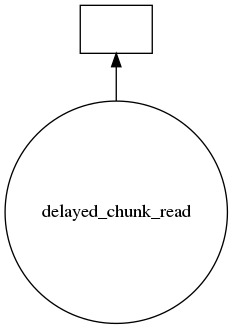

In [8]:
delayed_reader.delayed_chunks[0].visualize()

and then computed:

In [9]:
data = delayed_reader.delayed_chunks[0].compute()
data

({'PartType0': array([[ 7.62706518, 11.81260395,  0.51281077],
         [ 7.63057852, 11.81363678,  0.51373756],
         [ 7.63129807, 11.81438828,  0.51488519],
         ...,
         [ 0.45964792,  4.38608456, 24.28530502],
         [ 0.47030389,  4.36017942, 24.28691673],
         [ 0.46088085,  4.3528862 , 24.29429436]])},
 {('PartType0',
   'Mass'): array([0.01157142, 0.00970557, 0.01207049, ..., 0.00869689, 0.00905876,
         0.00865211], dtype=float32)},
 {'PartType0': 233206},
 {'PartType0': array([0.00544863, 0.00460062, 0.00578095, ..., 0.05705114, 0.06473364,
         0.06326077])})

In [10]:
data[0]

{'PartType0': array([[ 7.62706518, 11.81260395,  0.51281077],
        [ 7.63057852, 11.81363678,  0.51373756],
        [ 7.63129807, 11.81438828,  0.51488519],
        ...,
        [ 0.45964792,  4.38608456, 24.28530502],
        [ 0.47030389,  4.36017942, 24.28691673],
        [ 0.46088085,  4.3528862 , 24.29429436]])}

the returned object is a tuple of dicts containing the coordinates (`data[0]`), field values (`data[1]`), total particles (`data[2]`) and smoothing array (`data[3]`) organized by particle type. S

Now let's visualize the full list of delayed objects using `dask.visualize` 

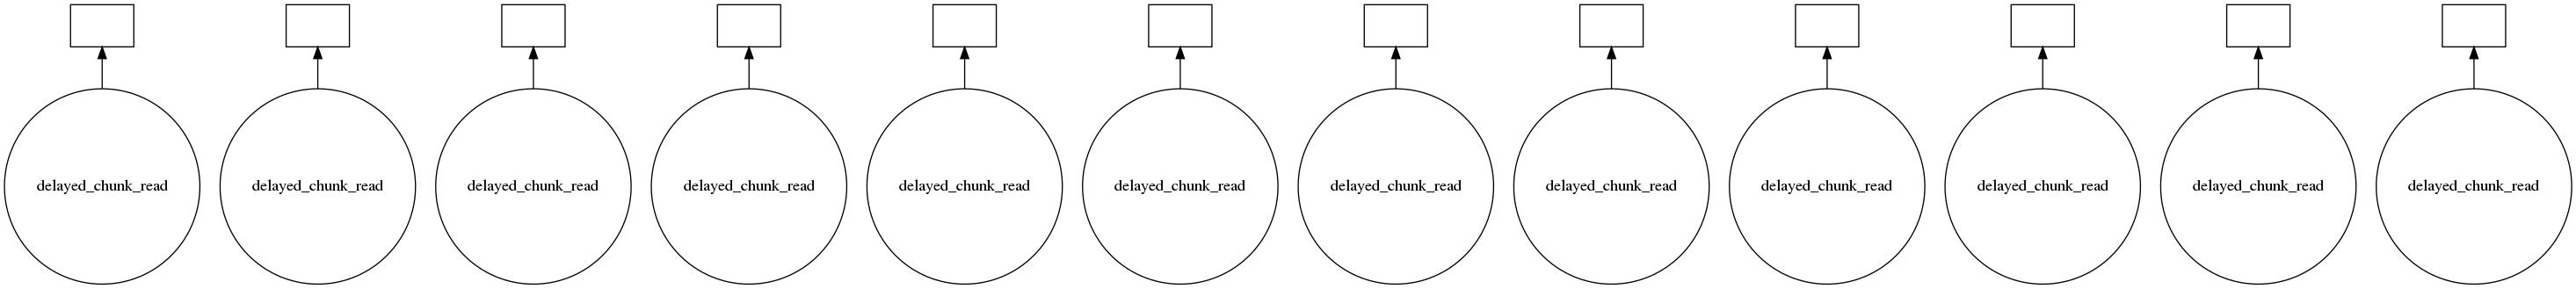

In [11]:
visualize(*delayed_reader.delayed_chunks)

which shows that each process is independent (good for parallelizing!) and we can bring the entire dataset into memory with:

In [12]:
%%time
all_data = compute(*delayed_reader.delayed_chunks)

CPU times: user 70.1 ms, sys: 68.5 ms, total: 139 ms
Wall time: 1.95 s


In [13]:
all_data[:2]

(({'PartType0': array([[ 7.62706518, 11.81260395,  0.51281077],
          [ 7.63057852, 11.81363678,  0.51373756],
          [ 7.63129807, 11.81438828,  0.51488519],
          ...,
          [ 0.45964792,  4.38608456, 24.28530502],
          [ 0.47030389,  4.36017942, 24.28691673],
          [ 0.46088085,  4.3528862 , 24.29429436]])},
  {('PartType0',
    'Mass'): array([0.01157142, 0.00970557, 0.01207049, ..., 0.00869689, 0.00905876,
          0.00865211], dtype=float32)},
  {'PartType0': 233206},
  {'PartType0': array([0.00544863, 0.00460062, 0.00578095, ..., 0.05705114, 0.06473364,
          0.06326077])}),
 ({'PartType0': array([], shape=(0, 3), dtype=float64)},
  {},
  {'PartType0': 0},
  {'PartType0': array([], dtype=float64)}))

here's a screenshot of the Task Stream graph on the dask client dashboard from this execution (see the [Dask Dahboard walkthrough tutorial for details](https://www.youtube.com/watch?time_continue=21&v=N_GqzcuGLCY&feature=emb_logo)):

![TaskStream](resources/daskboard_read.png)

which shows the processor and thread activity throughout the `compute()`: each row is a different thread (our client is using 4 workers with 2 threads per workers here, so 8 rows) and each chunk is a different `delayed_chunk_read`. 

Ok, so now we have a delayed workflow to load in chunks -- but we want to be able to do at least two additional processing steps:
1. compute derived quantities
2. filter the chunked objects 

and we want to do the bulk of the computation in parallel without loading the full dataset into memory -- meaning we want to string together delayed computations to be executed across the processors. Let's start with the simpler problem: computing derived quantities.

## derived quantities

Calculating derived quantities on each chunk is fairly straightforward. Let's write a delayed function to return some attributes and simple function calls so that we can return some array attribute values like `min()`, `max()`, `size` given a particle type and field:

In [14]:
import dask 
@dask.delayed 
def npmeth(chunk,ptype_field,meths=['min']): 
     
    results = []  
    if len(chunk)>0:   
        if ptype_field in chunk[1].keys():
            x = chunk[1][ptype_field]
            for meth in meths: 
                this_meth = getattr(x,meth)
                if callable(this_meth):
                    results.append(this_meth())
                else:
                    results.append(this_meth) 
    return results

Now we call this method using a single delayed chunk for a given particle type and field:

In [15]:
one_chunk_quantities = npmeth(delayed_reader.delayed_chunks[0],('PartType0','Mass'),meths=['min','max','sum'])

In [16]:
one_chunk_quantities

Delayed('npmeth-b22bc36e-9b1f-4d66-8402-718aba23f16a')

and when we call compute, we'll get the `min`, `max`, and `sum` of `('PartType0','Mass')` on a single chunk:

In [17]:
one_chunk_quantities.compute()

[0.008643857, 0.077581525, 2047.0905]

so to compute a derived quantity in parallel, we simply construct a list of delayed objects to calculate the quantitity on each chunk and then agreggate over the chunks:

In [18]:
meths = ['min','max','sum']
ptypefield = ('PartType0','Mass')
derived_qs = [npmeth(chunk,ptypefield,meths=meths) for chunk in delayed_reader.delayed_chunks]
derived_qs

[Delayed('npmeth-c0e6142e-22b0-4ecd-bfbf-1940380ca069'),
 Delayed('npmeth-20a85b20-6fcc-4a33-87b8-be90d0877af9'),
 Delayed('npmeth-459ac27d-b9cb-4f4f-9442-e2de1f006446'),
 Delayed('npmeth-4f12cda0-75ea-42b7-a107-2ad44f8123b6'),
 Delayed('npmeth-5e8d690e-e20a-42dd-aad8-2e642a6dd8fe'),
 Delayed('npmeth-f77eb553-ccda-4aa4-834f-4fb0eced9ec4'),
 Delayed('npmeth-22cb765d-851d-4242-9b92-6f3fc37b774e'),
 Delayed('npmeth-428f8804-d627-40e2-bc64-6036c16fe08b'),
 Delayed('npmeth-67565de9-f984-4498-a523-3e43cf4143fc'),
 Delayed('npmeth-9c8001c4-e9ff-4e94-8ad7-fc4a8cc245eb'),
 Delayed('npmeth-84ba7a5d-1ddb-42c9-a14d-9f593ab6b193'),
 Delayed('npmeth-d72a9b3f-460a-488d-9550-d4030ebcff69')]

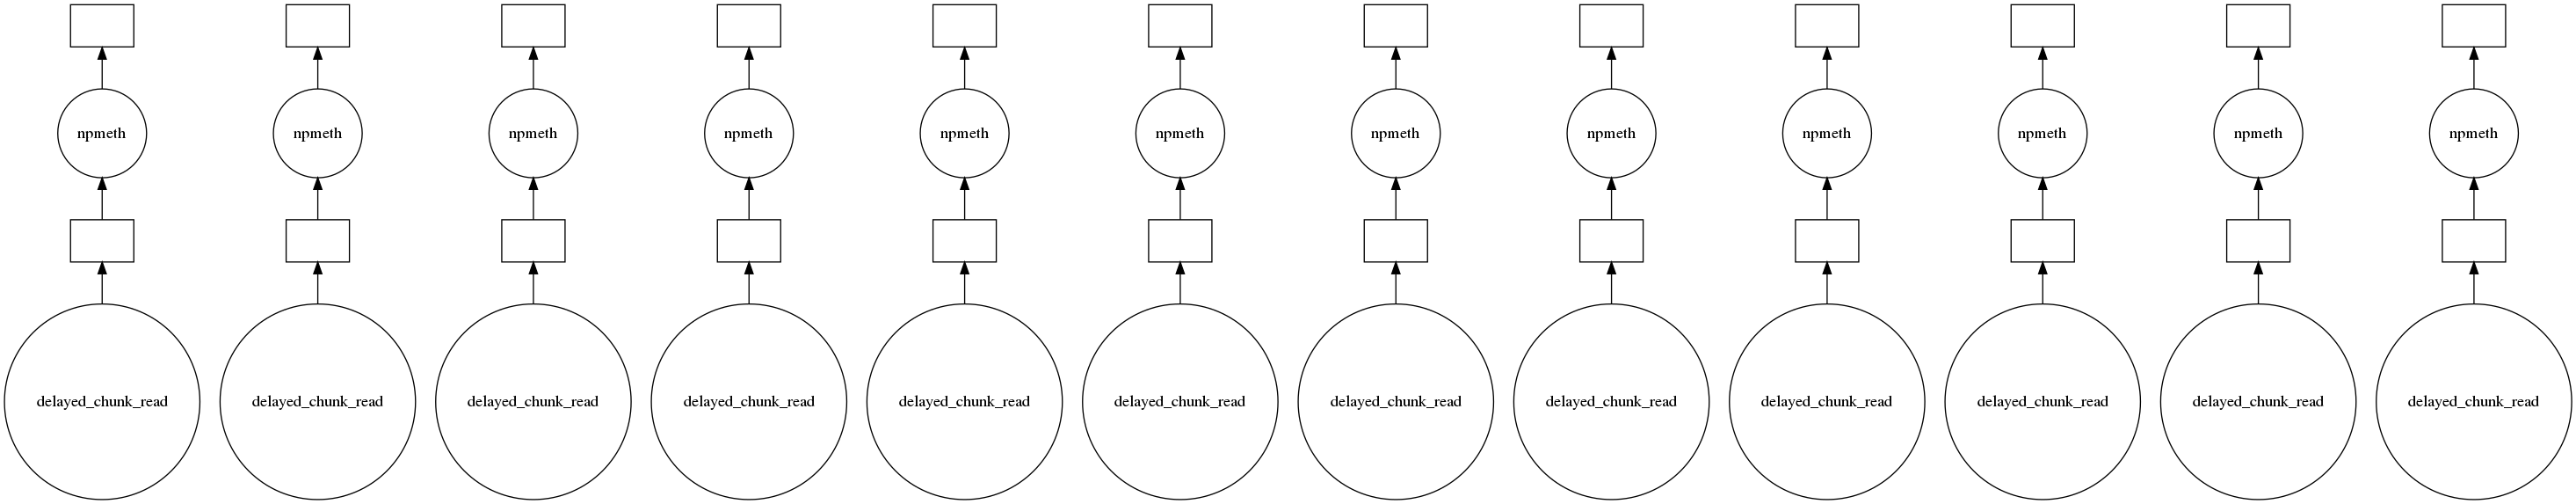

In [19]:
visualize(derived_qs)

Now we see that after each `delayed_chunk_read` we'll be applything this `npmeth` function, so so when we call

In [20]:
%%time
computed_derived = compute(*derived_qs)

CPU times: user 28.5 ms, sys: 0 ns, total: 28.5 ms
Wall time: 46 ms


And we see the additional `npmeth` calls in the Task Stream:

![TaskStream](resources/daskboard_derived.png)

some of the loads do not have accompanying reads because not all the chunks contain data for the given particle type, which we can see by checking out the full data set that we've already loaded:

In [21]:
[ad[2]['PartType0'] for ad in all_data]

[233206, 0, 255819, 419, 239908, 227868, 262144, 251598, 0, 0, 244445, 225819]

So that, along with the 5-10ms downtime between some of the tasks indicates that there's certainly some optimization to focus on.... but we'll leave that for later. 

So let's return to a derived quantities question: how to calculate global derived quantities across chunks? In the case of the simple quantities we're calculating here, we can manually aggregate across chunks easily. To calculate a mean across chunks, for example we can return the sum and count for each chunk then aggregate:

In [22]:
%%time
meths = ['size','sum']
ptypefield = ('PartType0','Mass')
derived_qs = [npmeth(chunk,ptypefield,meths=meths) for chunk in delayed_reader.delayed_chunks]
derived_qs = compute(*derived_qs)

# collect and compute mean
derived_qs = np.array([l for l in derived_qs if len(l)>0]) # remove empty chunks 
global_mean = derived_qs[:,1].sum() / derived_qs[:,0].sum() 
global_mean

CPU times: user 39.2 ms, sys: 4.34 ms, total: 43.5 ms
Wall time: 52.9 ms


0.008771999763740388

The derived quantities could be more involved, and we'll need to think more carefully about more complex quantities that require data from other chunks during computation, but let's move on to filtering....

## filtering 

What we want to be able to do is to use a yt selection data container, for example:

In [23]:
sp = ds.sphere(ds.domain_center,(2,'code_length')) 

and build a delayed process that will return only the subset of coordinates within each chunk falling within the selection. The conceptual approach is simple enough, we'd just write another delayed function to string onto the chunk reading, but in practice we run into some difficulty. The object that we really need is `sp.selector`:

In [24]:
sp.selector

now, if we were to do something like:

```
@dask.delayed 
def get_chunk_masks(ptf,chunk,selector):
```

dask will try to serialize the selector object with pickle, which fails: 

```
import pickle
pickle.dumps(sp.selector)
```

returns the following traceback:

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-85-5c86acc10898> in <module>
      1 import pickle
----> 2 pickle.dumps(sp.selector)

~/src/yt/yt/geometry/selection_routines.cpython-37m-x86_64-linux-gnu.so in yt.geometry.selection_routines.SphereSelector.__reduce_cython__()

TypeError: no default __reduce__ due to non-trivial __cinit__
```

which points to an issue in serializing the cython selection routine. When trying to implement the `get_chunk_masks` above, dask returns an error message stating that the selector object cannot be serialized (`distributed.protocol.core - CRITICAL - Failed to Serialize`).  

As a first approach, we'll look at what is required for initializing the `sphere` selector: 

In [25]:
sel = sp.selector
sel

In [26]:
ad = ds.all_data() 
n0 = 100000 
n1 = 500000
hsmls = 0 
mask = sel.select_points(
                ad['x'][n0:n1], ad['y'][n0:n1], ad['z'][n0:n1], hsmls
            )
print(mask[mask].shape)

(5109,)


YTSelectionContainer in yt/data_objects/selection_objects/data_selection_objects.py

is where the selector attribute is set:

```
@property
    def selector(self):
        if self._selector is not None:
            return self._selector
        s_module = getattr(self, "_selector_module", yt.geometry.selection_routines)
        sclass = getattr(s_module, f"{self._type_name}_selector", None)
        if sclass is None:
            raise YTDataSelectorNotImplemented(self._type_name)

        if self._data_source is not None:
            self._selector = compose_selector(
                self, self._data_source.selector, sclass(self)
            )
        else:
            self._selector = sclass(self)
        return self._selector
```        

In [27]:
s_module = yt.geometry.selection_routines
s_module

<module 'yt.geometry.selection_routines' from '/home/chavlin/src/yt/yt/geometry/selection_routines.cpython-37m-x86_64-linux-gnu.so'>

In [28]:
sp._type_name

'sphere'

In [29]:
sclass = s_module.sphere_selector
sclass

yt.geometry.selection_routines.SphereSelector

In [30]:
sp_sel = sclass(sp)

let's create a `MockSphere` class that pulls out only the minimal attributes needed to initialize the sphere selector: 

```
class MockDs(object):
    def __init__(self,ds):
        self.domain_left_edge = ds.domain_left_edge
        self.domain_right_edge = ds.domain_right_edge
        self.periodicity = ds.periodicity
        
class MockSphere(object):
    # a stripped down sphere that records only the attributes required to initialize the sphere Selector Object
    def __init__(self,sp):
        self.center = sp.center 
        self.radius = sp.radius
        self.ds = MockDs(sp.ds)            
```        

In [31]:
sp_M = gda.MockSphere(sp)

In [32]:
sp_M.center

unyt_array([12.5, 12.5, 12.5], 'code_length')

Now let's initialize our sphere selector with the mock class: 

In [33]:
sel_M = sclass(sp_M)

In [34]:
n0 = 100000 
n1 = 500000
ad = ds.all_data()
mask_2 = sel_M.select_points(
                ad['x'][n0:n1], ad['y'][n0:n1], ad['z'][n0:n1], hsmls
            )
print(mask_2[mask_2].shape)

(5109,)


In [35]:
np.all(mask_2==mask)

True

so looks like our sphere selector built from the mock class is behaving as expected. and our `sp_M` object should be easily pickleable:

In [36]:
import pickle 
sp_M_pi = pickle.dumps(sp_M)

which can be loaded back in (which dask does behind the scenes for each processor): 

In [37]:
sp_M_unpi = pickle.loads(sp_M_pi) # dask would do this in the backend

So within the delayed function for calculating masks, we can instantiate our selector using the mock class: 

In [38]:
sel_M = yt.geometry.selection_routines.SphereSelector(sp_M_unpi)

at present, our exploratory `delayed_gadget` class implements this approach just for the sphere selector (different selector objects required different attributes for initialization). But let's build a new `delayed_reader` supplying our mock sphere:

In [39]:
delayed_reader = gda.delayed_gadget(ds, ptf, mock_selector = sp_M, subchunk_size = None)

now we have two more lists of dealyed objects: `masks` and `masked_chunks`. The `masks` are delayed objects which return the boolean masks: 

In [40]:
delayed_reader.masks

[Delayed('get_chunk_masks-e72c7f2b-2f79-40ac-985a-1335afa052d3'),
 Delayed('get_chunk_masks-965cf793-8e04-44f4-9c44-f453480b2fa4'),
 Delayed('get_chunk_masks-70cacf79-07b4-4da5-a66c-10f5bc46f934'),
 Delayed('get_chunk_masks-b9c93750-d8f7-412e-8055-183065db5e2f'),
 Delayed('get_chunk_masks-a4e19e29-f8b2-4bf3-8c50-0141476b0b46'),
 Delayed('get_chunk_masks-a4a995b4-fa5c-4ba0-9bf6-6e5367e2e72c'),
 Delayed('get_chunk_masks-bc842f9b-bc08-4c58-a6ad-4e22476b21b7'),
 Delayed('get_chunk_masks-0a37431f-5b6f-4d1b-b148-118f098be207'),
 Delayed('get_chunk_masks-08b07c0a-d4d5-4dbd-905d-09d387f46c95'),
 Delayed('get_chunk_masks-a404509e-7c13-43cc-9ac1-4a8a880907d0'),
 Delayed('get_chunk_masks-91310ea2-c9bb-4231-87ee-041974a87cb2'),
 Delayed('get_chunk_masks-04886f16-65c2-49e2-9e77-b60a745189dc')]

In [41]:
chunk_1_mask = delayed_reader.masks[0].compute()
chunk_1_mask

{'PartType0': (array([False, False, False, ..., False, False, False]), 7156)}

so we could compute those masks and apply them to the delayed chunks, but the `masked_chunks` list contains delayed functions that load the chunks, masks and then returns just the masked values:  

In [42]:
masked_chunk_1 = delayed_reader.masked_chunks[0].compute()
masked_chunk_1

({'PartType0': array([[12.40897083, 11.28258801, 11.81107712],
         [12.41020012, 11.28173542, 11.81221294],
         [12.41038513, 11.28312969, 11.81461811],
         ...,
         [13.11116409, 11.26555443, 12.98612309],
         [13.38894558, 11.18954372, 12.92433167],
         [13.38833237, 11.18933868, 12.92260551]])},
 {('PartType0',
   'Mass'): array([0.01105031, 0.01259088, 0.01301601, ..., 0.00866676, 0.03573753,
         0.0319961 ], dtype=float32)})

and now when we compute the full list, dask will distribute the chunk reading and masking to individual processes: 

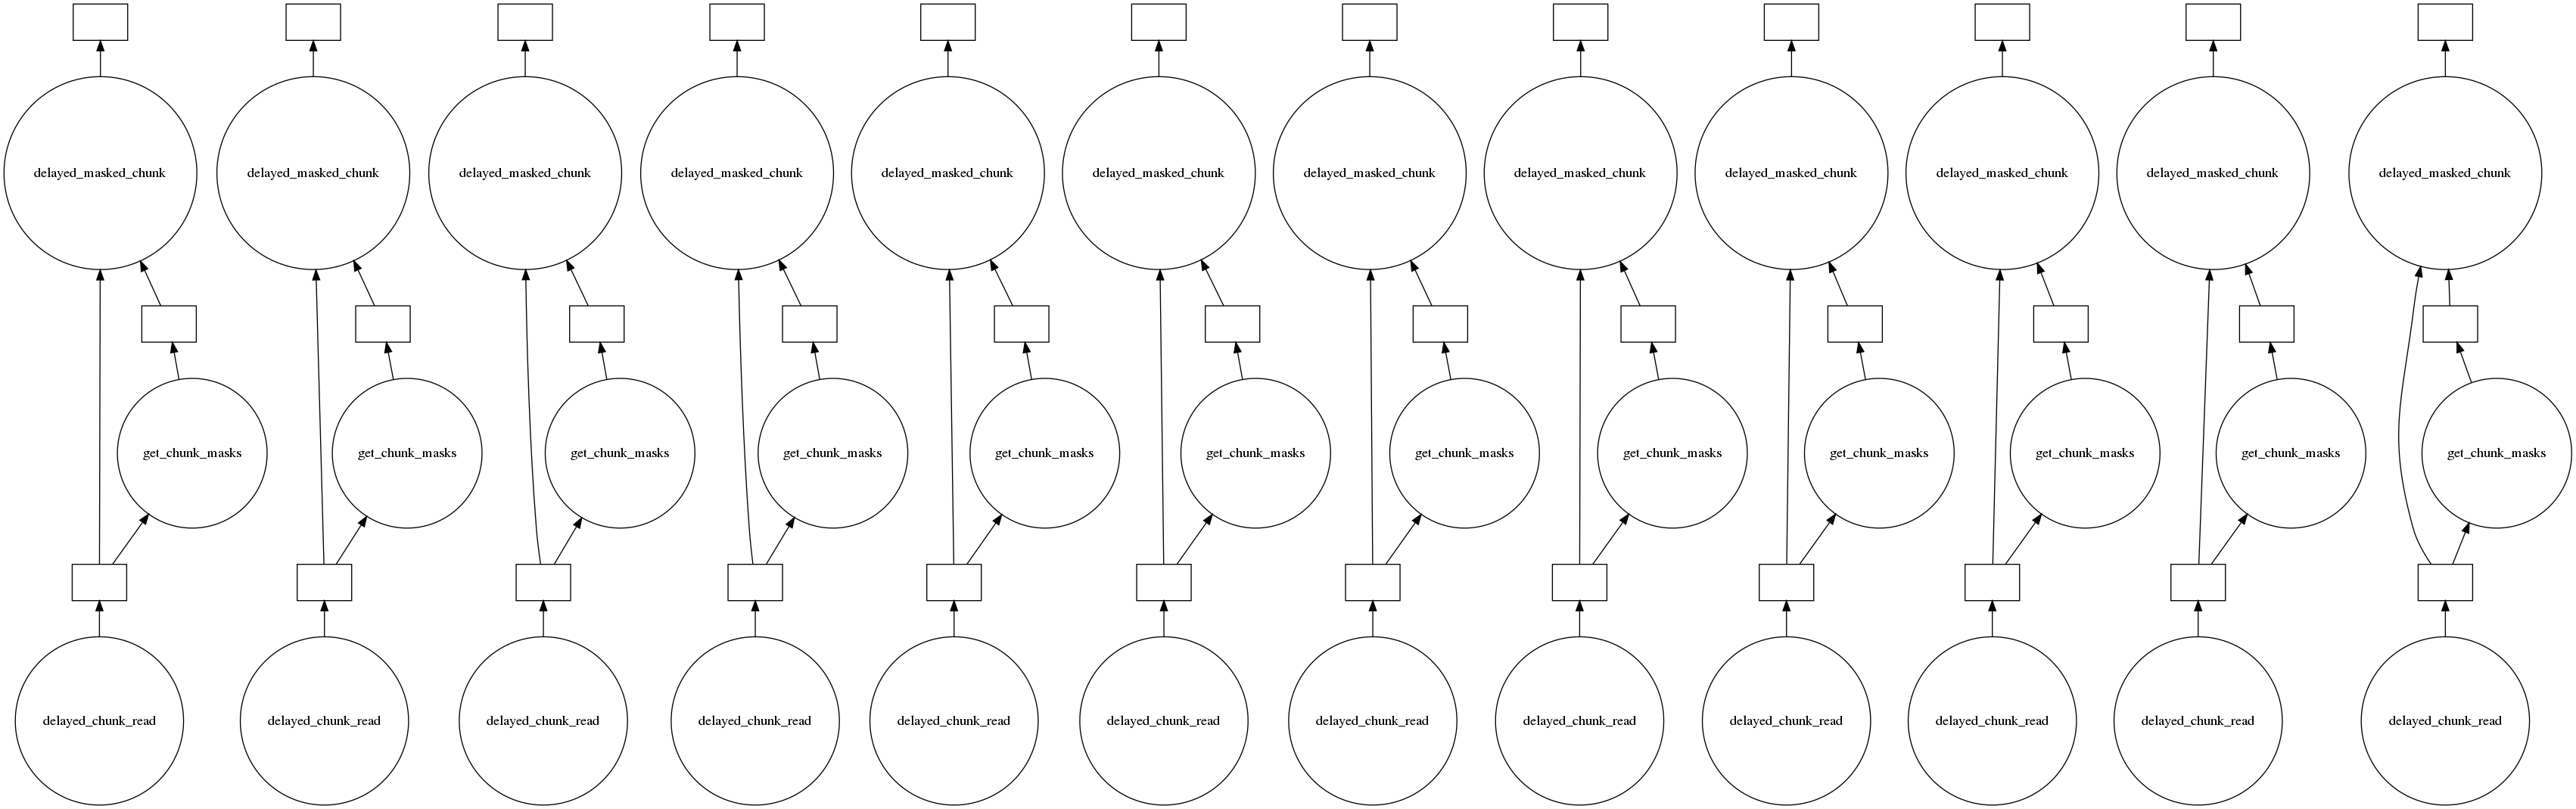

In [43]:
visualize(delayed_reader.masked_chunks)

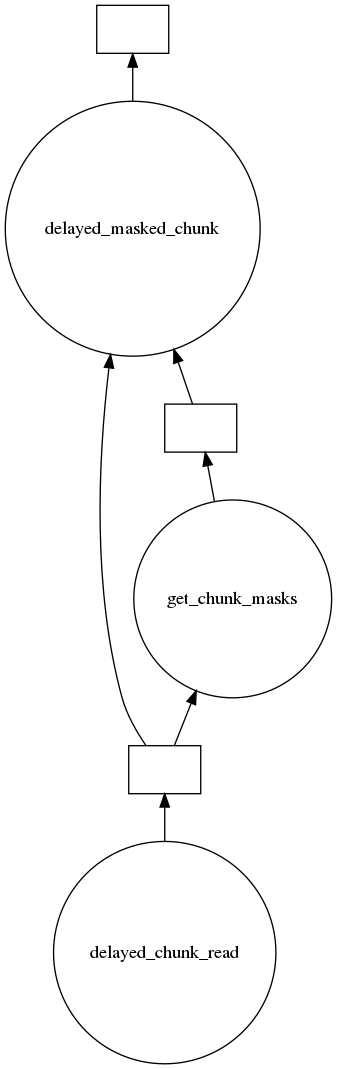

In [44]:
visualize(delayed_reader.masked_chunks[0])

In [45]:
data_subset = compute(*delayed_reader.masked_chunks)

And we now see the reading (purple), retrieving of masks (green) and applying the masks (yellow) in the task stream:

![TaskStream](resources/daskboard_masking.png)

and our `data_subset` contains only the masked data:

In [47]:
data_subset

(({'PartType0': array([[12.40897083, 11.28258801, 11.81107712],
          [12.41020012, 11.28173542, 11.81221294],
          [12.41038513, 11.28312969, 11.81461811],
          ...,
          [13.11116409, 11.26555443, 12.98612309],
          [13.38894558, 11.18954372, 12.92433167],
          [13.38833237, 11.18933868, 12.92260551]])},
  {('PartType0',
    'Mass'): array([0.01105031, 0.01259088, 0.01301601, ..., 0.00866676, 0.03573753,
          0.0319961 ], dtype=float32)}),
 ({'PartType0': array([], shape=(1, 0, 3), dtype=float64)}, {}),
 ({'PartType0': array([[13.4385376 , 11.04317665, 12.57679367],
          [13.4385128 , 11.05965042, 12.59449577],
          [13.47732162, 11.07425117, 12.56700706],
          ...,
          [13.38940811, 11.19235039, 12.9252739 ],
          [13.38981056, 11.19226837, 12.92547035],
          [13.3897171 , 11.19199467, 12.92544365]])},
  {('PartType0',
    'Mass'): array([0.0089119 , 0.00896248, 0.00876433, ..., 0.01497461, 0.01153182,
          0.0268

## misc notes 

What's this `subchunk_size`? When reading a single chunk, we're reading an index range in a single hdf file. In the `delayed_gadget` class, if `subchunk_size` is None, we just read the full index range into a numpy array. If it is not None, it will return dask arrays split by `subchunk_size`. So far, this generally slows things down:


In [48]:
delayed_reader = gda.delayed_gadget(ds, ptf, subchunk_size = 10000)

In [49]:
%%time
all_data = compute(*delayed_reader.delayed_chunks)

CPU times: user 61.1 ms, sys: 80.2 ms, total: 141 ms
Wall time: 180 ms


which is slower than without the subchunking by about 30 ms. The derived quantity calculate also slows down as dask has a bit more overhead communication to manage the different chunks

In [50]:
%%time
meths = ['size','sum']
ptypefield = ('PartType0','Mass')
derived_qs = [npmeth(chunk,ptypefield,meths=meths) for chunk in delayed_reader.delayed_chunks]
derived_qs = compute(*derived_qs)

CPU times: user 51.8 ms, sys: 5.47 ms, total: 57.2 ms
Wall time: 80.6 ms


so for the **present** test gadget dataset and current exploratory loader, we don't get any speed up (though if we had memory issues in loading single chunks, the subchunking should help that).  

As an additional aside, I made one failed attempt to use dask's hdf dataframe reader to import the gadget hdf files. The underlying pandas hdf reader has a limited expected structure for hdf files and can't handle the gadget h5py hdf files, so we need `h5py` to load and access data....
